这一个文件主要是主要是对meltome altas文献中的数据进行处理。meltome altas的数据来自于两部分，分别是cross-species.csv和human.csv，分别储存了13种物种的蛋白质数据和人类细胞系中的蛋白质数据。cross-species.csv中也有两个人类细胞系的数据。

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import os
os.chdir('/data/zhangjian/graduate_project/dataset_for_Tm')
meltome_dataset = pd.read_csv('meltome_data/cross-species.csv')


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

def process_tm_data(tm_data, length_threshold=3, alpha=0.05, diff_threshold=3, std_threshold=3):
    # 将输入的 Tm 数据字符串转换为浮点数列表
    tm_values = [float(tm) for tm in tm_data.split('/')]

    # 计算四分位数和箱体高度
    q1 = np.percentile(tm_values, 25)
    q3 = np.percentile(tm_values, 75)
    iqr = q3 - q1
    if len(tm_values) == 1:
        mean_tm = np.mean(tm_values)
    elif len(tm_values) == 2 and abs(tm_values[0] - tm_values[1]) <= diff_threshold:
        # 两个数据，差值小于等于3，计算平均值
        mean_tm = np.mean(tm_values)
    elif 3 <= len(tm_values) <= 4:
        # 三个或四个数据，使用肖维勒准则检验
        mean_value = np.mean(tm_values)
        std_dev = np.std(tm_values)
        # 计算Z得分
        z_scores = np.abs((tm_values - mean_value) / std_dev)
        threshold_z_score = 2.5
        data_filtered = [val for val, z_score in zip(tm_values, z_scores) if z_score <= threshold_z_score]
        std = np.max(data_filtered) - np.min(data_filtered)
        if std <= diff_threshold:
            mean_tm = np.mean(data_filtered)
        else:
            mean_tm = np.nan 
    elif len(tm_values) >= 5:
        # 五个及以上数据，使用原有算法（箱线图 + 肖维勒准则检验）
        if iqr < length_threshold:
        # 获取箱体内的数据
            #data_inside_box = [tm for tm in tm_values if q1 - 1.5 * iqr <= tm <= q3 + 1.5 * iqr]
            data_inside_box = [tm for tm in tm_values if q1<= tm <= q3]
        # 使用肖维勒准则检测箱体内数据是否存在异常值
            mean_data_inside_box = np.mean(data_inside_box)
            std_data_inside_box = np.std(data_inside_box)
            z_scores = np.abs((data_inside_box - mean_data_inside_box) / std_data_inside_box)

        # 设置阈值，如果存在任何一个数据点的Z得分超过阈值，则移除整组数据
            threshold_z_score = 2.5
            if np.any(z_scores > threshold_z_score):
                mean_tm = np.nan
            else:
                mean_tm = mean_data_inside_box 
        else:
            mean_tm = np.nan
    else:
        # 其他情况，无法满足条件，返回 NaN
        mean_tm = np.nan

    return mean_tm

人类蛋白质的标识符是gene_name，我们需要先将gene name匹配到对应的uniprot ID上，匹配的文件来自于uniprot网站的idmap，当然也可以使用ensemble网站的biomart工具。

In [ ]:
id_map = pd.read_csv('human_ID.tsv',sep='\t')
meltome_data1 = pd.merge(meltome_dataset,id_map[['From','Entry']],left_on='gene_name',right_on='From',how='left')
meltome_data1.loc[~meltome_data1['Protein_ID'].notna(),'Protein_ID'] = meltome_data1.loc[~meltome_data1['Protein_ID'].notna(),'Entry']

In [ ]:
meltome_data2 = meltome_data1.iloc[:,:7]
meltome_data3 = meltome_data2[meltome_data2['Protein_ID'].notna() & meltome_data2['meltPoint'].notna()]

In [ ]:
meltome_P_torridus = meltome_data3[meltome_data3['run_name']=='Picrophilus torridus DSM9790 lysate']
meltome_P_torridus['OGT'] = 60
meltome_G_stearothermophilus = meltome_data3[meltome_data3['run_name']=='Geobacillus stearothermophilus NCA26 lysate']
meltome_G_stearothermophilus['OGT'] = 55
meltome_T_thermophilus = pd.concat([meltome_data3[meltome_data3['run_name']=='Thermus thermophilus HB27 cells'], meltome_data3[meltome_data3['run_name']=='Thermus thermophilus HB27 lysate']],axis=0)
meltome_T_thermophilus['OGT'] = 70
meltome_D_melanogaster = meltome_data3[meltome_data3['run_name']=='Drosophila melanogaster SII lysate']
meltome_D_melanogaster['OGT'] = 28
meltome_B_subtilis = meltome_data3[meltome_data3['run_name']=='Bacillus subtilis_168_lysate_R1']
meltome_B_subtilis['OGT'] = 30
meltome_O_antarctica = meltome_data3[meltome_data3['run_name']=='Oleispira antarctica_RB-8_lysate_R1']
meltome_O_antarctica['OGT'] = 15
meltome_S_cerevisiae = meltome_data3[meltome_data3['run_name']=='Saccharomyces cerevisiae lysate']
meltome_S_cerevisiae['OGT'] = 30
meltome_E_coli = pd.concat([meltome_data3[meltome_data3['run_name']=='Escherichia coli cells'], meltome_data3[meltome_data3['run_name']=='Escherichia coli lysate']],axis=0)
meltome_E_coli['OGT'] = 37
meltome_A_thaliana = meltome_data3[meltome_data3['run_name']=='Arabidopsis thaliana seedling lysate']
meltome_A_thaliana['OGT'] = 25
meltome_D_rerio = meltome_data3[meltome_data3['run_name']=='Danio rerio Zenodo lysate']
meltome_D_rerio['OGT'] = 28
meltome_C_elegans = meltome_data3[meltome_data3['run_name']=='Caenorhabditis elegans lysate']
meltome_C_elegans['OGT'] = 20
meltome_M_musculus = pd.concat([meltome_data3[meltome_data3['run_name']=='Mus musculus BMDC lysate'], meltome_data3[meltome_data3['run_name']=='Mus musculus liver lysate']],axis=0)
meltome_M_musculus['OGT'] = 37
meltome_Jurkat = meltome_data3[meltome_data3['run_name']=='Homo sapiens Jurkat cells']
meltome_Jurkat['OGT'] = 37
meltome_K562 = meltome_data3[meltome_data3['run_name']=='Homo sapiens K562 cells']
meltome_K562['OGT'] = 37

In [ ]:
result_P_torridus = handle_data(meltome_P_torridus)
result_G_stearothermophilus =handle_data(meltome_G_stearothermophilus)
result_T_thermophilus =handle_data(meltome_T_thermophilus)
result_D_melanogaster =handle_data(meltome_D_melanogaster)
result_B_subtilis =handle_data(meltome_B_subtilis)
result_O_antarctica =handle_data(meltome_O_antarctica)
result_S_cerevisiae =handle_data(meltome_S_cerevisiae)
result_E_coli =handle_data(meltome_E_coli)
result_A_thaliana =handle_data(meltome_A_thaliana)
result_D_rerio =handle_data(meltome_D_rerio)
result_C_elegans =handle_data(meltome_C_elegans)
result_M_musculus =handle_data(meltome_M_musculus)
result_Jurkat =handle_data(meltome_Jurkat)
result_K562 =handle_data(meltome_K562)

In [ ]:
data_sum=pd.concat([
result_P_torridus
,result_G_stearothermophilus
,result_T_thermophilus
,result_D_melanogaster
,result_B_subtilis
,result_O_antarctica
,result_S_cerevisiae
,result_E_coli
,result_A_thaliana
,result_D_rerio
,result_C_elegans
,result_M_musculus
,result_Jurkat
,result_K562],axis=0)
data_sum = data_sum.drop_duplicates(subset='Protein_ID')
#data_sum.to_csv('/data/zhangjian/graduate_project/dataset_for_Tm/meltome_sum/meltome_species.csv')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import os
os.chdir('/data/zhangjian/graduate_project/dataset_for_Tm/meltome_data')

In [ ]:
import pandas as pd
import requests
from io import BytesIO
import gzip
def uniprot_get(input_data):
    gene_id = input_data
    #这一部分的网址url是需要根据自己的需求进行调整的。
    #url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Cid&format=tsv&query=%28%28gene%3A{gene_id}%29+AND+%28taxonomy_id%3A9606%29+AND+%28reviewed%3Atrue%29'
    url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Cid&format=tsv&query=%28%28gene%3A{gene_id}%29+AND+%28taxonomy_id%3A9606%29+AND+%28reviewed%3Atrue%29%29'
    #url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Cid&format=tsv&query=%28%28id%3A{gene_id}%29+AND+%28taxonomy_id%3A9606%29%29+AND+%28reviewed%3Atrue%29'
    #url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Cid&format=tsv&query=%28%28taxonomy_id%3A9606%29+AND+%28id%3A{gene_id}%29%29'
    response = requests.get(url)

    if response.status_code == 200:
            # 从响应中解压缩数据
            with gzip.GzipFile(fileobj=BytesIO(response.content), mode='rb') as f:
            # 读取解压缩后的数据并创建DataFrame
                temp = pd.read_csv(f, sep='\t')
                if temp.shape[0] == 0:
                    print(f'no result for {gene_id}')
                    return np.nan
                elif temp.shape[0] == 1:
                    uniprot_ID = temp.loc[0,'Entry']
                    return uniprot_ID
                elif temp.shape[0]>1:
                    print(f'duplicate results for {gene_id}')
    else:
        print(f"no found for {gene_id}")
        pass

In [ ]:
#meltome_cell是收集的全集，一共有1858170条蛋白质，无空值。其中总共10919个蛋白质。
meltome_cell = pd.read_csv('human.csv')
#meltome_cell_match是ensemble网站biomart中gene name对应的reviewed和unreviewed数据。
meltome_cell_match = pd.read_csv('meltome_altas_cell_id.txt',sep='\t')
cell_gene = pd.DataFrame(set(meltome_cell['gene_name']))
cell_gene.columns = ['gene_name']
#pd.DataFrame(set(meltome_cell['gene_name'])).to_csv('meltome_cell_gene.csv')

In [ ]:
#meltome_cell_match2是对biomart中的记录进行合并，将reviewed蛋白质和unreviewed蛋白质分别合并，共有9264个蛋白质匹配到了reviewed蛋白质。
meltome_cell_match2 = meltome_cell_match.groupby('Gene name').agg({'UniProtKB/Swiss-Prot ID': lambda x: set(x.dropna()),
                                         'UniProtKB/TrEMBL ID': lambda x: set(x.dropna())})
meltome_cell_match2[meltome_cell_match2['UniProtKB/Swiss-Prot ID']!={}]
meltome_cell_match2.reset_index(inplace=True)
meltome_cell_match2.columns = ['Gene name','reviewed','unreviewed']
meltome_cell_match2['reviewed'] = meltome_cell_match2['reviewed'].astype(str).str.extract(r"(\w+)")
meltome_cell2 = pd.merge(cell_gene,meltome_cell_match2,left_on='gene_name',right_on='Gene name',how='left')
meltome_cell2 = meltome_cell2.drop_duplicates(subset='gene_name')

In [ ]:
#meltome_cell2_left是没有匹配到ensemble中biomart的基因名称(1655个)，现在再使用uniprot网站进行一次匹配。共1408个匹配到了唯一的reviewed蛋白质。
meltome_cell2_left = meltome_cell2[~meltome_cell2['reviewed'].notna()]
meltome_cell2_left['reviewed'] = meltome_cell2_left['gene_name'].apply(uniprot_get)

In [ ]:
#meltome_cells是前面两次匹配中所有匹配上的蛋白质的合集,共10672条。
meltome_cell3 = pd.concat([meltome_cell2[meltome_cell2['reviewed'].notna()],meltome_cell2_left[meltome_cell2_left['reviewed'].notna()]],axis=0)
meltome_cell['meltPoint'] = meltome_cell['meltPoint'].astype(str)
#meltome_cell_zip是将所有细胞系下相同的gene_name对应的蛋白质合并。共计59550个蛋白质
meltome_cell_zip = meltome_cell.groupby(['gene_name','cell_line_or_type'])['meltPoint'].apply(lambda x: '/'.join(set(x))).reset_index()
meltome_cell_zip = pd.DataFrame(meltome_cell_zip)
meltome_cell_zip['Tm'] = meltome_cell_zip['meltPoint'].apply(mean_tm_data)

In [ ]:
#将meltome_cell_zip的gene_name匹配到uniprot ID上，59550个蛋白质有58564个匹配到了uniprot ID。
data_meltome_cell = pd.merge(meltome_cell_zip,meltome_cell3,left_on='gene_name',right_on='gene_name',how='left')
data_meltome_cell = data_meltome_cell.drop_duplicates(subset=['gene_name','cell_line_or_type'])
data_meltome_cell = data_meltome_cell[['gene_name','cell_line_or_type','meltPoint','Tm','reviewed']]
#为了方便后续的画图统计，这里将所有Tm为空的值去除了。
data_meltome_cell = data_meltome_cell[data_meltome_cell['Tm'].notna()]
#data_meltome_cell.to_csv('meltome_cell.csv')

In [7]:
meltome_species = pd.read_csv('meltome_sum/meltome_species.csv',)
meltome_cell = pd.read_csv('meltome_sum/meltome_cell.csv')

In [8]:
data_cell =  meltome_cell[['reviewed','cell_line_or_type','Tm']]
data_cell.columns = ['Uniprot_ID','cell_line','Tm']
data_species =  meltome_species[['Protein_ID','run_name','meltPoint']]
data_species.columns = ['Uniprot_ID','run_name','Tm']
data_sum = pd.concat([data_cell,data_species],axis=0)

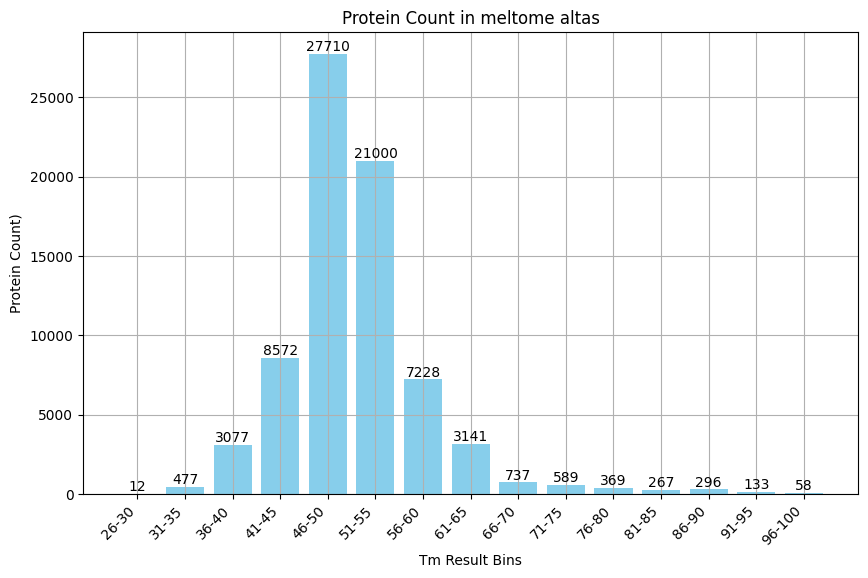

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# 划分区段
bins = range(26, 100 + 6, 5)

# 计算每个分组中的蛋白质数量
counts, bin_edges = np.histogram(data_sum['Tm'], bins=bins)

# 对数量进行对数变换
counts_log = counts

# 绘制条形图
plt.figure(figsize=(10, 6))


bars = plt.bar(range(len(counts_log)), counts_log, color='skyblue')
plt.bar(range(len(counts_log)), counts_log, color='skyblue')
plt.title('Protein Count in meltome altas')
plt.xlabel('Tm Result Bins')
plt.ylabel('Protein Count)')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{counts_log[i]}",
             ha='center', va='bottom')
    
plt.yticks(np.arange(0, np.floor(counts_log.max()) + 1, 5000))
plt.xticks(range(len(bins)-1), [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)], rotation=45, ha='right')
# 添加网格线
plt.grid(True)

plt.show()

In [41]:
filtered_df = data_sum.groupby('Uniprot_ID').apply(lambda x: x.loc[x['Tm'].idxmin()])

# 重置索引
filtered_df.reset_index(drop=True, inplace=True)
df_filtered = pd.DataFrame(filtered_df)
# 输出筛选后的DataFrame
print(filtered_df)

                       Uniprot_ID cell_line         Tm  \
0            A0A023PXQ4_YMR173W-A       NaN  52.403034   
1                     A0A023T4K3_       NaN  37.962947   
2               A0A023T778_Magohb       NaN  54.932539   
3                A0A061ACF5_fbl-1       NaN  49.459216   
4      A0A061ACH4_CELE_Y62E10A.13       NaN  42.593131   
...                           ...       ...        ...   
31876                 Z4YLI8_Cluh       NaN  48.622640   
31877                 Z4YLT1_Inip       NaN  47.647866   
31878                Z4YLT8_Rnf11       NaN  56.953592   
31879             Z4YNA9_AB124611       NaN  55.222178   
31880                         set      K562  42.480940   

                              run_name  
0      Saccharomyces cerevisiae lysate  
1        Caenorhabditis elegans lysate  
2             Mus musculus BMDC lysate  
3        Caenorhabditis elegans lysate  
4        Caenorhabditis elegans lysate  
...                                ...  
31876         Mu

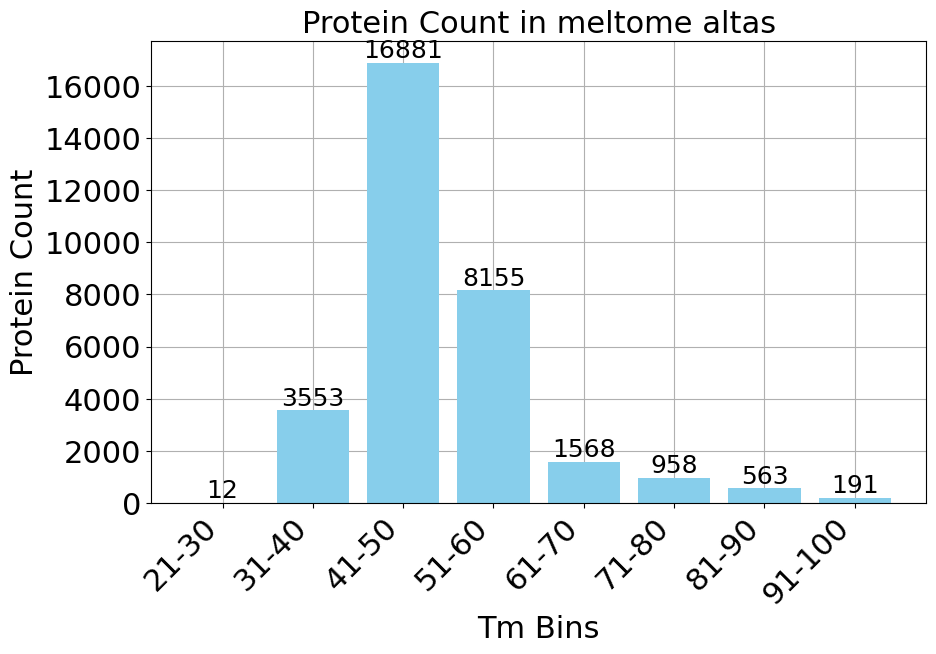

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 划分区段
bins = range(21, 100 + 6, 10)

# 计算每个分组中的蛋白质数量
counts, bin_edges = np.histogram(df_filtered['Tm'], bins=bins)

# 对数量进行对数变换
counts_log = counts

# 绘制条形图
plt.figure(figsize=(10, 6))

bars = plt.bar(range(len(counts_log)), counts_log, color='skyblue')
plt.bar(range(len(counts_log)), counts_log, color='skyblue')
plt.title('Protein Count in meltome altas',fontsize=22)
plt.xlabel('Tm Bins',fontsize=22)
plt.ylabel('Protein Count',fontsize=22)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{counts_log[i]}",
             ha='center', va='bottom',fontsize=18)
    
plt.yticks(np.arange(0, np.floor(counts_log.max()) + 1, 2000),fontsize=22)
plt.xticks(range(len(bins)-1), [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)], rotation=45, ha='right',fontsize=22)

# 绘制网格线，并将它置于底部
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

